In [1]:
# import

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from path import Path
import os
import json


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### MODEL

In [3]:
class Encoder (nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, latent_dims)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x): #x : torch.Size([64, 2, 400])
        x = torch.flatten(x, start_dim=1) # x.shape : torch.Size([64, 800])
        x = self.relu(self.fc1(x)) # x.shape : torch.Size([64, 512]) 
        return self.fc2(x) #shape = torch.Size([64, 5])

In [86]:
class Decoder (nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dims, 512)
        self.fc2 = nn.Linear(512, 800)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.sigmoid(self.fc2(z)) #z.shape : torch.Size([64, 800])
        z = torch.reshape(z, (-1, 400, 2)) #뒤에서도 사용할려면 64대신 일반화 해야함.
        return z

In [87]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [88]:
def loss_function(self):
    pass

## DATA

In [89]:
class DRPointData(Dataset):
    def __init__(self, root_dir, valid=False):
        self.root_dir = root_dir
        self.valid = valid
        self.files = [_ for _ in os.listdir(root_dir) if _.endswith('.json')]
        
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, file):
        with open(file) as f:
            np_points = np.array(json.load(f))
            nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto').fit(np_points)
            matrix = torch.from_numpy(nbrs.kneighbors_graph(np_points).toarray())
            points = torch.from_numpy(np_points)
            max_val = torch.max(points, -2).values.view(1, -1)
            min_val = torch.min(points, -2).values.view(1, -1)
            diff = max_val - min_val
            points = (points - min_val) / diff
        return {'points': points,
               'KNN':matrix}
        
    def __getitem__(self, idx):
        json_file = os.path.join(self.root_dir, self.files[idx])
        item = self.__preproc__(json_file)
        return item
        

In [90]:
path = Path("data")
train_dr = DRPointData(path)

In [91]:
#X = train_dr[0]
#X['KNN'][0]

In [92]:
dataloader = DataLoader(dataset=train_dr, batch_size=64, drop_last=True)

## train

In [93]:
def train(model, dataloader, epochs=5):
#    opt = torch.optim.Adam(autoencoder.parameters()) // TODO : How to use
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        print(epoch)
        autoencoder.train()
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, kNN = data['points'].to(device).float(), data['KNN'].to(device).int()
            optimizer.zero_grad()
            x_hat = autoencoder(inputs.transpose(1, 2))
            loss = ((inputs - x_hat)**2).sum()
            loss.backward()
            optimizer.step()
    return model

In [94]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)


In [95]:
autoencoder = train(autoencoder, dataloader)

0
1
2
3
4


In [114]:
def plot_latent(model, dataloader, num_batches=100):
    for i, x in enumerate(dataloader):
        x = x['points']
        #print(x.shape)
        z = model.encoder(x.to(device).float())
        z = z.to('cpu').detach().numpy()
        # 64개씩 끊어서
        plt.scatter(z[:, 0], z[:, 1], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

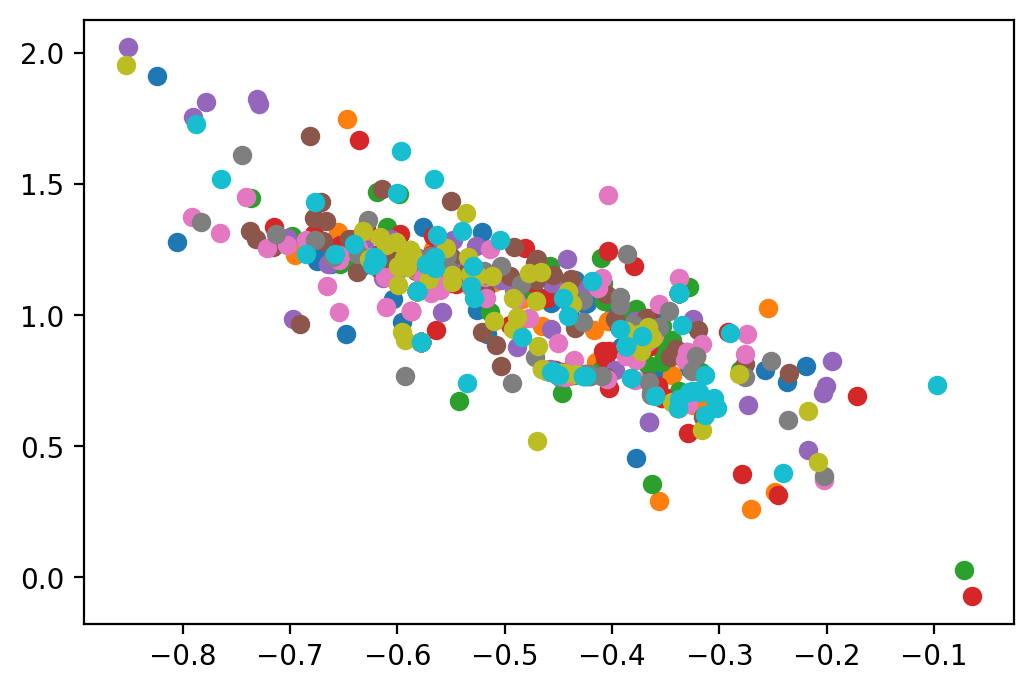

In [115]:
plot_latent(autoencoder, dataloader)

In [96]:
def plot_reconstructed(autoencoder, r0=(-2, 0), r1=(0, 1), n=4):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z) #(64, 2) 넣어야 함.
            #x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            #img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    #plt.imshow(img, extent=[*r0, *r1])

In [97]:
plot_reconstructed(autoencoder)

torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])
